# Water

In this notebook we'll explore the Extenden Single Point Charge (SPC/E) model for water.

In [1]:
import os
import sys
import re

sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from read_lammps_log import read_log, get_temp_lognames, read_rdf_log
from diffusion import get_diffusion_constant

sns.set(color_codes=True)

In [2]:
%%writefile spce-simple.lt

# (NOTE: Text following # characters are comments)
#
# file "spce_simple.lt"
#
# H1 H2
# \/
# O
#
SPCE {
    # LAMMPS supports a large number of force-field styles. We must select
    # which ones we need. This information belongs in the "In Init" section.
    write_once("In Init") {
        units real # angstroms, kCal/mole, Daltons, Kelvin
        atom_style full # select column format for Atoms section
        pair_style lj/cut/coul/long 10.35 # params needed: epsilon sigma
        bond_style harmonic # parameters needed: k_bond, r0
        angle_style harmonic # parameters needed: k_theta, theta0
        kspace_style ewald 0.0001 # long-range electrostatics sum method
        pair_modify tail yes
    }
    ## Atom properties and molecular topology go in the various "Data ..." sections
    # We selected "atom_style full". That means we use this column format:
    # atomID molID atomType charge coordX coordY coordZ
    write("Data Atoms") {
        $atom:O $mol:. @atom:O -0.8476 0.0000000 0.000000 0.00000
        $atom:H1 $mol:. @atom:H 0.4238 0.8164904 0.5773590 0.00000
        $atom:H2 $mol:. @atom:H 0.4238 -0.8164904 0.5773590 0.00000
    }
    # All 3 atoms share same molID number which is unique for each water molecule
    # The "O" & "H1","H2" atoms in ALL molecules share same atom types: "O" & "H"
    write_once("Data Masses") {
        @atom:O 15.9994
        @atom:H 1.008
    }
    write("Data Bonds") {
        # bondID bondType atomID1 atomID2
        $bond:OH1 @bond:OH $atom:O $atom:H1
        $bond:OH2 @bond:OH $atom:O $atom:H2
    }
    write("Data Angles") {
        # angleID angleType atomID1 atomID2 atomID3
        $angle:HOH @angle:HOH $atom:H1 $atom:O $atom:H2
    }
    # --- Force-field parameters go in the "In Settings" section: ---
    write_once("In Settings") {
        # -- Non-bonded (Pair) interactions --
        # atomType1 atomType2 parameter-list (epsilon, sigma)
        pair_coeff @atom:O @atom:O 0.1553 3.5532
        pair_coeff @atom:H @atom:H 0.0 2.058
        # (mixing rules determine interactions between types @atom:O and @atom:H)
        # -- Bonded interactions --
        # bondType parameter list (k_bond, r0)
        bond_coeff @bond:OH 554.1349 1.0
        # angleType parameter-list (k_theta, theta0)
        angle_coeff @angle:HOH 45.7696 109.47
        # Group definitions and constraints can also go in the "In Settings" section
        group spce type @atom:O @atom:H
        #fix fSHAKE spce shake 0.0001 10 100 b @bond:OH a @angle:HOH
        # (lammps quirk: Remember to "unfix fSHAKE" during minimization.)
    }
} # SPCE

Overwriting spce-simple.lt


In [3]:
%%writefile spce-water-system.lt

# -- file "spce-water-system.lt" --
import "spce-simple.lt"

wat = new SPCE [10].move(0,0,3.45)
               [10].move(0,3.45,0)
               [10].move(3.45,0,0)

write_once("Data Boundary") {
    0.0 34.5 xlo xhi
    0.0 34.5 ylo yhi
    0.0 34.5 zlo zhi
}

Overwriting spce-water-system.lt


In [4]:
!moltemplate.sh -atomstyle "full" spce-water-system.lt

moltemplate.sh v2.10.15 2019-5-02

lttree_check.py v0.80.1 2017-10-01

    "Data Atoms" column format:
    atom-ID molecule-ID atom-type q x y z


    "Data Atoms" column format:
    atom-ID molecule-ID atom-type q x y z

lttree_check.py:    parsing the class definitions... done
lttree_check.py:    looking up classes... done
lttree_check.py:    looking up @variables... done
lttree_check.py: -- No errors detected. --
lttree.py v0.80.0 2018-10-16 
(python version 3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0])

    "Data Atoms" column format:
    atom-ID molecule-ID atom-type q x y z

parsing the class definitions... done
looking up classes... done
looking up @variables... done
constructing the tree of class definitions... done

class_def_tree = (SPCE(O, H, OH, HOH))

constructing the instance tree...
  processing command "InstantiateCommand(wat[0][0][0])"
  processing command "InstantiateCommand(wat[0][0][1])"
  processing command "InstantiateCommand(wat[0][0][2])"

  processing command "InstantiateCommand(wat[2][3][5])"
  processing command "InstantiateCommand(wat[2][3][6])"
  processing command "InstantiateCommand(wat[2][3][7])"
  processing command "InstantiateCommand(wat[2][3][8])"
  processing command "InstantiateCommand(wat[2][3][9])"
  processing command "InstantiateCommand(wat[2][4][0])"
  processing command "InstantiateCommand(wat[2][4][1])"
  processing command "InstantiateCommand(wat[2][4][2])"
  processing command "InstantiateCommand(wat[2][4][3])"
  processing command "InstantiateCommand(wat[2][4][4])"
  processing command "InstantiateCommand(wat[2][4][5])"
  processing command "InstantiateCommand(wat[2][4][6])"
  processing command "InstantiateCommand(wat[2][4][7])"
  processing command "InstantiateCommand(wat[2][4][8])"
  processing command "InstantiateCommand(wat[2][4][9])"
  processing command "InstantiateCommand(wat[2][5][0])"
  processing command "InstantiateCommand(wat[2][5][1])"
  processing command "InstantiateCommand(wat[2][

  processing command "InstantiateCommand(wat[4][2][6])"
  processing command "InstantiateCommand(wat[4][2][7])"
  processing command "InstantiateCommand(wat[4][2][8])"
  processing command "InstantiateCommand(wat[4][2][9])"
  processing command "InstantiateCommand(wat[4][3][0])"
  processing command "InstantiateCommand(wat[4][3][1])"
  processing command "InstantiateCommand(wat[4][3][2])"
  processing command "InstantiateCommand(wat[4][3][3])"
  processing command "InstantiateCommand(wat[4][3][4])"
  processing command "InstantiateCommand(wat[4][3][5])"
  processing command "InstantiateCommand(wat[4][3][6])"
  processing command "InstantiateCommand(wat[4][3][7])"
  processing command "InstantiateCommand(wat[4][3][8])"
  processing command "InstantiateCommand(wat[4][3][9])"
  processing command "InstantiateCommand(wat[4][4][0])"
  processing command "InstantiateCommand(wat[4][4][1])"
  processing command "InstantiateCommand(wat[4][4][2])"
  processing command "InstantiateCommand(wat[4][

  processing command "InstantiateCommand(wat[5][8][9])"
  processing command "InstantiateCommand(wat[5][9][0])"
  processing command "InstantiateCommand(wat[5][9][1])"
  processing command "InstantiateCommand(wat[5][9][2])"
  processing command "InstantiateCommand(wat[5][9][3])"
  processing command "InstantiateCommand(wat[5][9][4])"
  processing command "InstantiateCommand(wat[5][9][5])"
  processing command "InstantiateCommand(wat[5][9][6])"
  processing command "InstantiateCommand(wat[5][9][7])"
  processing command "InstantiateCommand(wat[5][9][8])"
  processing command "InstantiateCommand(wat[5][9][9])"
  processing command "InstantiateCommand(wat[6][0][0])"
  processing command "InstantiateCommand(wat[6][0][1])"
  processing command "InstantiateCommand(wat[6][0][2])"
  processing command "InstantiateCommand(wat[6][0][3])"
  processing command "InstantiateCommand(wat[6][0][4])"
  processing command "InstantiateCommand(wat[6][0][5])"
  processing command "InstantiateCommand(wat[6][

  processing command "InstantiateCommand(wat[8][9][2])"
  processing command "InstantiateCommand(wat[8][9][3])"
  processing command "InstantiateCommand(wat[8][9][4])"
  processing command "InstantiateCommand(wat[8][9][5])"
  processing command "InstantiateCommand(wat[8][9][6])"
  processing command "InstantiateCommand(wat[8][9][7])"
  processing command "InstantiateCommand(wat[8][9][8])"
  processing command "InstantiateCommand(wat[8][9][9])"
  processing command "InstantiateCommand(wat[9][0][0])"
  processing command "InstantiateCommand(wat[9][0][1])"
  processing command "InstantiateCommand(wat[9][0][2])"
  processing command "InstantiateCommand(wat[9][0][3])"
  processing command "InstantiateCommand(wat[9][0][4])"
  processing command "InstantiateCommand(wat[9][0][5])"
  processing command "InstantiateCommand(wat[9][0][6])"
  processing command "InstantiateCommand(wat[9][0][7])"
  processing command "InstantiateCommand(wat[9][0][8])"
  processing command "InstantiateCommand(wat[9][

In [13]:
%%writefile scripts/water.in

include "spce-water-system.in"

variable bins equal 200

timestep 1.0
fix   fxnpt all npt temp ${T} ${T} 100.0 iso 1.0 1.0 1000.0 drag 1.0
#dump  1 all custom 10 dat/water_${T}.lammpstrj id mol type x y z ix iy iz

thermo 10
run 2000

reset_timestep 0
# Add com to remove drift in the system. Water is running all over the place.
compute msd all msd com yes
compute myrdf all rdf ${bins}

variable time equal dt*step

fix 2 all ave/time 100 1 100 c_myrdf[*] file dat/water_rdf_${T}.log mode vector

thermo_style custom step v_time temp ke pe etotal press c_msd[4]
log dat/water_g_${T}.log


thermo 10
run   5000

Overwriting scripts/water.in


In [20]:
%%writefile scripts/run_water_simulations.sh

export OMP_NUM_THREADS=4

for T in $(seq 100 10 400); do
    mpirun -np 4 lmp -var T $T -in scripts/water.in
done

Overwriting scripts/run_water_simulations.sh


In [ ]:
!bash scripts/run_water_simulations.sh

In [43]:
temperature_list, file_list = get_temp_lognames("water_g")

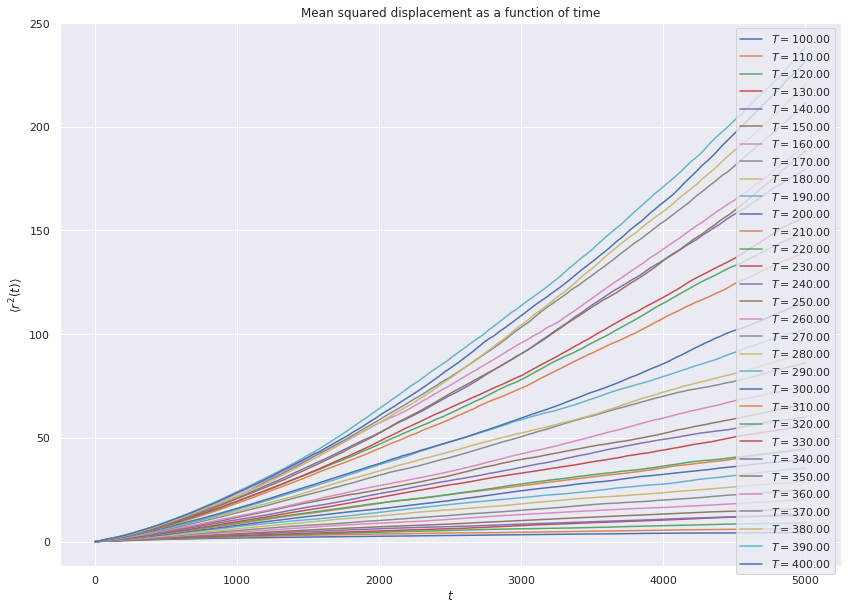

In [54]:
fig = plt.figure(figsize=(14, 10))

log_df_list = []

for T, filename in zip(temperature_list, file_list):
    log_df = read_log(filename)
    log_df_list.append(log_df)
    plt.plot(
        log_df["v_time"],
        log_df["c_msd[4]"],
        label=fr"$T = {T:.2f}$"
    )

plt.xlabel(r"$t$")
plt.ylabel(r"$\langle r^2(t)\rangle$")
plt.legend(loc="best")
plt.title(r"Mean squared displacement as a function of time")
plt.show()

In [45]:
D_list = []
alpha_list = []

for T, log_df in zip(temperature_list, log_df_list):
    D, D_int, alpha, alpha_int = get_diffusion_constant(log_df)

    D_list.append(D)
    alpha_list.append(alpha)

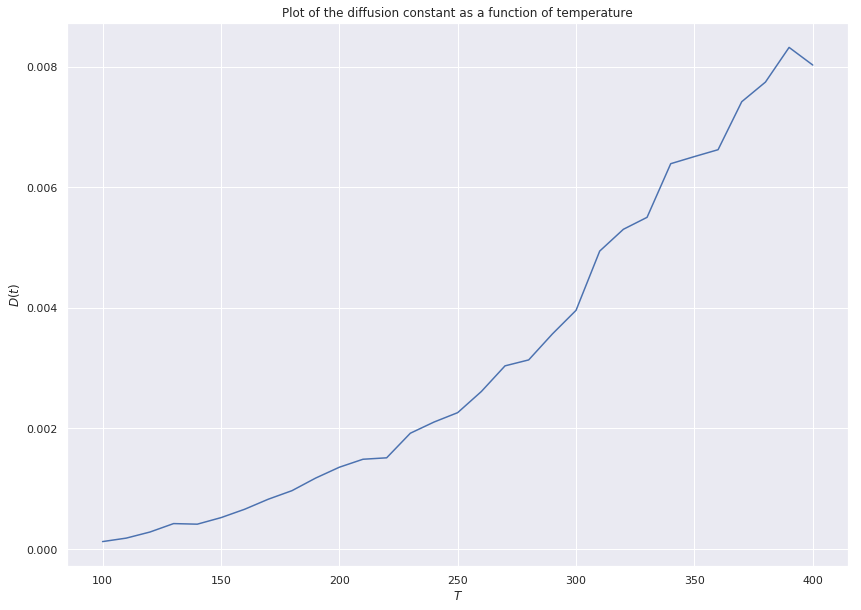

In [53]:
fig = plt.figure(figsize=(14, 10))

plt.plot(temperature_list, D_list)
plt.title(r"Plot of the diffusion constant as a function of temperature")
plt.xlabel(r"$T$")
plt.ylabel(r"$D(t)$")
plt.show()

We are not able to see a clear phase transition as a function of temperature for water. This has much to do with our model as it is hard to create ice for the model we are using.

In [55]:
temperature_list, rdf_list = get_temp_lognames("water_rdf")

In [56]:
g_r_dict = {}
bin_centers_dict = {}

for temp, filename in zip(temperature_list, rdf_list):
    bin_centers, g_r = read_rdf_log(filename)

    g_r_dict[temp] = g_r
    bin_centers_dict[temp] = bin_centers

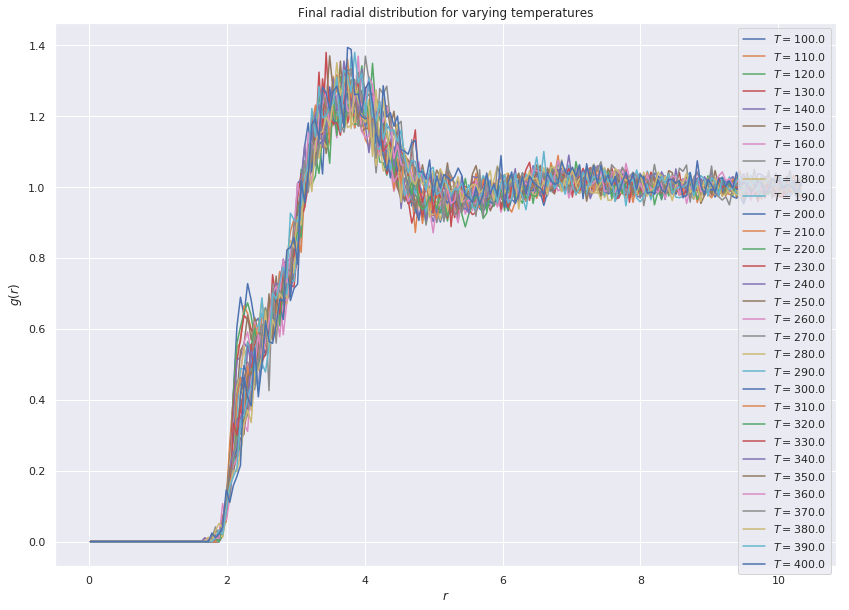

In [57]:
fig = plt.figure(figsize=(14, 10))

for i, temp in enumerate(temperature_list):
    key = max(g_r_dict[temp])

    plt.plot(
        bin_centers_dict[temp][key],
        g_r_dict[temp][key],
        label=fr"$T = {temp}$",
    )

plt.xlabel(r"$r$")
plt.ylabel(r"$g(r)$")
plt.legend(loc="best")
plt.title(r"Final radial distribution for varying temperatures")
plt.show()

We can see how the peaks are smeared out when the temperature increases.